In [1]:
print("Hello word ")

Hello word 


In [2]:
# Imports uniques regroupés

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, Input


In [26]:
# (Dans l'autre notebook)
import pandas as pd
df_for_ml = pd.read_csv("./df_for_ml.csv")

In [27]:
df_for_ml["emotion_label"].value_counts()

emotion_label
calm         192
happy        192
sad          192
angry        192
disgust      192
fearful      192
surprised    192
neutral       96
Name: count, dtype: int64

- Séparation en train - Cross Validation - Test set

In [28]:
feature_cols = [c for c in df_for_ml.columns if c.startswith("f_")]
X = df_for_ml[feature_cols].to_numpy(dtype=np.float32)
y = df_for_ml["emotion_label"].to_numpy()

# 75% train, 15% val, 10% test
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.15, random_state=42, stratify=y_tmp
)



le = LabelEncoder()
le.fit(y_train)                      # fit sur TRAIN uniquement
y_train_int = le.transform(y_train)
y_val_int   = le.transform(y_val)
y_test_int  = le.transform(y_test)


print(X_train.shape, X_val.shape, X_test.shape)


(1101, 120) (195, 120) (144, 120)


- Centrer réduire les données d'entrainement

In [7]:


# créer l'objet de centrage réduction 
scaler = StandardScaler()                

# Apprendre les paramètres (moyenne/écart-type) sur le TRAIN uniquement
X_train = scaler.fit_transform(X_train).astype(np.float32)

# Réutiliser le MÊME scaler pour centrer/réduire VAL et TEST (pas de fit ici)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)



# Conception des modèles

In [9]:


def make_mse_onehot(num_classes: int):
    @tf.function
    def mse_onehot(y_true, y_pred):
        # y_true peut être (batch,) ou (batch,1) -> on squeeze et on cast
        y_true = tf.cast(tf.squeeze(y_true), tf.int32)
        y_true_oh = tf.one_hot(y_true, depth=num_classes)
        return tf.reduce_mean(tf.math.squared_difference(y_true_oh, y_pred))
    return mse_onehot


- Hyperparamètres


In [35]:
#Hyperparamètres
input_dim = X_train.shape[1]
num_classes = len(np.unique(y))
LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 64

In [65]:
def model_architecture(input_dim: int, num_classes: int,
                  dropout: float = 0.0, lambda_reg: float = 0.0, learning_rate: float = 0.001) -> keras.Model:
    inputs = layers.Input(shape=(input_dim,))
    reg = keras.regularizers.l2(lambda_reg)
    he_init = keras.initializers.HeNormal()

    x = layers.Dense(50, activation="relu",
                     kernel_regularizer=reg,
                     kernel_initializer=he_init)(inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(25, activation="relu",
                     kernel_regularizer=reg,
                     kernel_initializer=he_init)(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(16, activation="relu",
                     kernel_regularizer=reg,
                     kernel_initializer=he_init)(x)
    x = layers.Dropout(dropout)(x)

    probs = layers.Dense(num_classes, activation="softmax", name="softmax_layer")(x)
    model = keras.Model(inputs, probs, name="Model_nn")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"],
    )
    return model


In [66]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=50, min_lr=1e-5),
]

In [67]:
model_nn = model_architecture(input_dim, num_classes, dropout=0.0, lambda_reg=0.001)

model_nn.compile(
        optimizer=keras.optimizers.Adam(LEARNING_RATE),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"],
    )

histories = {} 
print("\n=== Entraînement model_nn ===")
histories["model_nn"] = model_nn.fit(
    X_train, y_train_int, validation_data=(X_val, y_val_int),
    callbacks=callbacks,
    epochs=200, batch_size=BATCH_SIZE,  verbose=1
)


=== Entraînement model_nn ===
Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.1281 - loss: 17.2390 - val_accuracy: 0.1436 - val_loss: 9.9997 - learning_rate: 0.0010
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1708 - loss: 6.6508 - val_accuracy: 0.1436 - val_loss: 4.0247 - learning_rate: 0.0010
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1662 - loss: 2.9288 - val_accuracy: 0.1846 - val_loss: 2.3936 - learning_rate: 0.0010
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2035 - loss: 2.2196 - val_accuracy: 0.1949 - val_loss: 2.2080 - learning_rate: 0.0010
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2289 - loss: 2.0512 - val_accuracy: 0.2564 - val_loss: 2.0876 - learning_rate: 0.0010
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2543 - loss: 1.9821 - val_accuracy: 0.2359 - val_loss: 2.0267 - learning_rate: 0.0010
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - ac

In [69]:
p_tr = model_nn.predict(X_train, verbose=0)
p_va = model_nn.predict(X_val,   verbose=0)
yhat_tr = p_tr.argmax(axis=1)
yhat_va = p_va.argmax(axis=1)

# Accuracy (train/val) and error
acc_train = accuracy_score(y_train_int, yhat_tr)
acc_val   = accuracy_score(y_val_int,   yhat_va)
err_train = 1.0 - acc_train
err_val   = 1.0 - acc_val


print("Accuracy (train/val): %.2f / %.2f" % (acc_train, acc_val))
print("Error    (train/val): %.2f / %.2f" % (err_train, err_val))

Accuracy (train/val): 0.67 / 0.48
Error    (train/val): 0.33 / 0.52


Best performance 
L2 = 0.0005
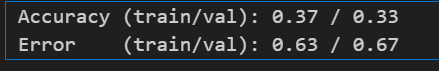